In [1]:
import mne
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import traceback
from multiprocessing.pool import Pool
import re
from functools import partial 
import multiprocessing as mp

In [2]:
def extract_time_ids(epoch_id, time_vector, timestamps_array, srate):
    temp = np.asfortranarray(np.subtract(time_vector,timestamps_array[epoch_id]))
    t_init_id = np.abs(temp).argmin() ## CANNOT BE ZERO, change to a not magic 
    t_end_id = int(np.floor(t_init_id+240*srate+1)) # 4 min = 240 s
    return (t_init_id, t_end_id)

In [3]:
# Function to extract info from each channel
def extract_channel_data(chn_number, edf_file, srate_data, time_ids):
    edf_in = pyedflib.EdfReader(edf_file)
    signal = edf_in.readSignal(chn_number)
    print(chn_number)
    chn_data = np.array([], dtype=float)
    for t_id in time_ids:
        chn_data = np.hstack([chn_data, 
                            signal[t_id[0]:t_id[1]], 
                            np.zeros(int(60*srate_data))])
    # Deallocate space in memory
    del signal
    return chn_data

In [4]:
def create_EDF(edf_file, time_stamps, electrodes_df):
    edf_in = pyedflib.EdfReader(edf_file)
    # First import labels
    labels_orig = edf_in.getSignalLabels()
    # print(labels_orig)
    bipolar_channels = create_bipolars(electrodes_df, 8)
    # Create file:
    edf_out = pyedflib.EdfWriter('test2.edf', len(bipolar_channels), file_type=pyedflib.FILETYPE_EDFPLUS)
    try:
        # First set the data from the header of the edf file:
        edf_out.setHeader(edf_in.getHeader())
        # f.datarecord_duration gives the value is sec and setDatarecordDuration receives it in units
        # of 10 ms. Therefore: setDatarecordDuration = datarecord_duration*10^6 / 10
        # int(edf_in.datarecord_duration*(100000)))
        edf_out.setDatarecordDuration(int(edf_in.datarecord_duration*100000)) # This actually is used to set the sample frequency
        # Set each channel info:
        # First create an empty list for the data
        channel_data = [np.array([], dtype=float) for chn in range(len(bipolar_channels))]
        # Sampling rate:
        srate = edf_in.getSampleFrequencies()[0]/edf_in.datarecord_duration
        # Build epochs
        N = edf_in.getNSamples()[0]
        # Time vector:
        t = np.arange(0, N)/srate
        # Relative initial time for epochs
        t_0 = t[np.abs(np.subtract(t,time_stamps[0])).argmin()]
        edf_out.writeAnnotation(0, -1, "Recording starts")
        # Create time ids
        list_epochs_ids = list(range(time_stamps.size))
        print('Time part')
        with Pool(processes=8) as pool:
            t_ids = pool.map(partial(extract_time_ids, time_vector=t, timestamps_array=time_stamps, srate=srate), 
                            list_epochs_ids)
        for id, (t_init_id, t_end_id) in enumerate(t_ids):
            # Write annotations
            edf_out.writeAnnotation(t[t_init_id]-t_0, -1, f"Epoch #{id+1} starts.")
            edf_out.writeAnnotation(t[t_end_id]-t_0, -1, f"Epoch #{id+1} ends.")
        # Deallocate space in memory
        del t
        headers_orig = edf_in.getSignalHeaders()
        headers = []
        for chn in range(len(bipolar_channels)):
            print(bipolar_channels[chn][0])
            chn1_id = labels_orig.index(bipolar_channels[chn][1])
            chn2_id = labels_orig.index(bipolar_channels[chn][2])
            print(chn1_id, chn2_id)
            # Update headers
            headers.append(headers_orig[chn1_id])
            headers[-1]['label'] = bipolar_channels[chn][0]
            signal_chn1 = edf_in.readSignal(chn1_id)
            signal_chn2 = edf_in.readSignal(chn2_id)
            for t_id in t_ids:
                signal_bipolar = signal_chn1[t_id[0]:t_id[1]] - signal_chn2[t_id[0]:t_id[1]]
                channel_data[chn] = np.hstack([channel_data[chn], signal_bipolar, np.zeros(int(60*srate))])
                # Deallocate space in memory
            del signal_chn1
            del signal_chn2
        # Close file:
        edf_in.close()
        print(f'Len channel data: {len(channel_data)}')
        print(f'Len headers: {len(headers)}')
        for header in headers:
            header['physical_max'] = int(header['physical_max'])
            header['physical_min'] = int(header['physical_min'])
            if len(str(header['physical_max']))>8:
                header['physical_max'] = int(str(header['physical_max'])[0:8])
            if len(str(header['physical_min']))>8:
                header['physical_min'] = int(str(header['physical_min'])[0:8])
        edf_out.setSignalHeaders(headers)
        edf_out.writeSamples(channel_data)
        edf_out.close()
    except Exception:
        traceback.print_exc()
        edf_out.close()

In [5]:
def create_bipolar_comb(id, dict_key, channels_dict):
    bipolar_chn = dict_key+channels_dict[dict_key][id]+'-'+channels_dict[dict_key][id+1] 
    chn1_label = dict_key+channels_dict[dict_key][id]
    chn2_label = dict_key+channels_dict[dict_key][id+1]
    return (bipolar_chn, chn1_label, chn2_label)

In [6]:
def create_bipolars(electrodes_df, processes):
    channels = dict((label,[]) for label in electrodes_df.orig_group.unique())
    pattern = r'([A-Z]+)(\d+)'
    electrode_labels = electrodes_df.label.values
    # Extract channels info
    for electrode in electrodes_df.label.values:
        match = re.match(pattern, electrode, re.IGNORECASE)
        channels[match.group(1)].append(match.group(2))
    # print(channels)
    # Create new list
    bipolar_list = []
    for key in  channels.keys():
        with Pool(processes=processes) as pool:
                bipolar_list = bipolar_list + pool.map(partial(create_bipolar_comb, dict_key=key, channels_dict=channels), 
                                        list(range(len(channels[key])-1)))
    return bipolar_list

## Test

In [7]:
file = "/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/epi_iEEG/ieeg/bids/sub-003/ses-007/ieeg/sub-003_ses-007_task-full_run-02_ieeg.edf"
f = pyedflib.EdfReader(file)

In [8]:
f.getSignalHeaders()[10]

{'label': 'RAm1',
 'dimension': 'uV',
 'sample_rate': 128.0,
 'sample_frequency': 128.0,
 'physical_max': -8711.0,
 'physical_min': 8711.0,
 'digital_max': 32767,
 'digital_min': -32768,
 'prefilter': '',
 'transducer': ''}

In [9]:
labels = f.getSignalLabels()
print(labels)
print(labels.index('RAm1'))

['ROFr1', 'ROFr2', 'ROFr3', 'ROFr4', 'ROFr5', 'ROFr6', 'ROFr7', 'ROFr8', 'ROFr9', 'ROFr10', 'RAm1', 'RAm2', 'RAm3', 'RAm4', 'RAm5', 'RAm6', 'RAm7', 'RAm8', 'RAm9', 'RAm10', 'RAHc1', 'RAHc2', 'RAHc3', 'RAHc4', 'RAHc5', 'RAHc6', 'RAHc7', 'RAHc8', 'RAHc9', 'RAHc10', 'RPHc1', 'RPHc2', 'RPHc3', 'RPHc4', 'RPHc5', 'RPHc6', 'RPHc7', 'RPHc8', 'RPHc9', 'RPHc10', 'RTeP1', 'RTeP2', 'RTeP3', 'RTeP4', 'RTeP5', 'RTeP6', 'RTeP7', 'RTeP8', 'RTeP9', 'RTeP10', 'RAIn1', 'RAIn2', 'RAIn3', 'RAIn4', 'RAIn5', 'RAIn6', 'RAIn7', 'RAIn8', 'RAIn9', 'RAIn10', 'RPIn1', 'RPIn2', 'RPIn3', 'RPIn4', 'RPIn5', 'RPIn6', 'RPIn7', 'RPIn8', 'RPIn9', 'RPIn10', 'RCeO1', 'RCeO2', 'RCeO3', 'RCeO4', 'RCeO5', 'RCeO6', 'RCeO7', 'RCeO8', 'RCeO9', 'RCeO10', 'LAHc1', 'LAHc2', 'LAHc3', 'LAHc4', 'LAHc5', 'LAHc6', 'LAHc7', 'LAHc8', 'LAHc9', 'LAHc10', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C100', 'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115',

In [10]:
# n_annot = len(f.readAnnotations()[0])
# annot = np.zeros([n_annot, 3])
annot = f.readAnnotations()
annot = {
    'Onset': annot[0],
    'Duration': annot[1],
    'event': annot[2]
}
annot = pd.DataFrame(annot)
annot.head()

,Onset,Duration,event
0,0.009766,-1.0,Breakout box reconnected.
1,2708.616211,-1.0,Clip Note
2,2718.341797,-1.0,awake trigger
3,3952.470703,-1.0,Patient Event
4,3971.615234,-1.0,Breakout box disconnected.


In [11]:
# Find time stamps where the 'awake trigger' event is happening
id = annot['event'].str.contains('awake trigger', case=False)
time_stamps = annot.Onset.to_numpy()[id]

In [12]:
f.getSignalHeader(123)

{'label': 'C124',
 'dimension': 'uV',
 'sample_rate': 128.0,
 'sample_frequency': 128.0,
 'physical_max': -8711.0,
 'physical_min': 8711.0,
 'digital_max': 32767,
 'digital_min': -32768,
 'prefilter': '',
 'transducer': ''}

In [13]:
len(labels)

148

In [14]:
len(f.getSignalHeaders())

148

In [20]:
# f.getSignalHeaders()[135:148]

In [15]:
# Find bipolar channels:
elec_pos = pd.read_csv('/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/seega_coordinates/sub-P003/sub-P003_space-native_SEEGA.tsv', sep='\t')
elec_pos.head()

,type,label,x,y,z,orig_group,new_label,new_group
0,SEEGA,LAHc1,-31.168,22.674,18.960,LAHc,LAHc1,LAHc
1,SEEGA,LAHc2,-35.115,22.649,18.819,LAHc,LAHc2,LAHc
2,SEEGA,LAHc3,-38.992,22.420,18.671,LAHc,LAHc3,LAHc
3,SEEGA,LAHc4,-42.815,22.358,18.633,LAHc,LAHc4,LAHc
4,SEEGA,LAHc5,-46.719,22.118,18.634,LAHc,LAHc5,LAHc


In [16]:
elec_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        90 non-null     object 
 1   label       90 non-null     object 
 2   x           90 non-null     float64
 3   y           90 non-null     float64
 4   z           90 non-null     float64
 5   orig_group  90 non-null     object 
 6   new_label   90 non-null     object 
 7   new_group   90 non-null     object 
dtypes: float64(3), object(5)
memory usage: 5.8+ KB


In [29]:
# Create bipolar list:
create_bipolars(elec_pos, 8)[0]

('LAHc1-2', 'LAHc1', 'LAHc2')

In [35]:
f.close()

In [43]:
if time_stamps.size > 0:
    # Here call function
    create_EDF(file, time_stamps, elec_pos)

Time part
LAHc1-2
80 81
LAHc2-3
81 82
LAHc3-4
82 83
LAHc4-5
83 84
LAHc5-6
84 85
LAHc6-7
85 86
LAHc7-8
86 87
LAHc8-9
87 88
LAHc9-10
88 89
RAHc1-2
20 21
RAHc2-3
21 22
RAHc3-4
22 23
RAHc4-5
23 24
RAHc5-6
24 25
RAHc6-7
25 26
RAHc7-8
26 27
RAHc8-9
27 28
RAHc9-10
28 29
RAIn1-2
50 51
RAIn2-3
51 52
RAIn3-4
52 53
RAIn4-5
53 54
RAIn5-6
54 55
RAIn6-7
55 56
RAIn7-8
56 57
RAIn8-9
57 58
RAIn9-10
58 59
RAm1-2
10 11
RAm2-3
11 12
RAm3-4
12 13
RAm4-5
13 14
RAm5-6
14 15
RAm6-7
15 16
RAm7-8
16 17
RAm8-9
17 18
RAm9-10
18 19
RCeO1-2
70 71
RCeO2-3
71 72
RCeO3-4
72 73
RCeO4-5
73 74
RCeO5-6
74 75
RCeO6-7
75 76
RCeO7-8
76 77
RCeO8-9
77 78
RCeO9-10
78 79
ROFr1-2
0 1
ROFr2-3
1 2
ROFr3-4
2 3
ROFr4-5
3 4
ROFr5-6
4 5
ROFr6-7
5 6
ROFr7-8
6 7
ROFr8-9
7 8
ROFr9-10
8 9
RPHc1-2
30 31
RPHc2-3
31 32
RPHc3-4
32 33
RPHc4-5
33 34
RPHc5-6
34 35
RPHc6-7
35 36
RPHc7-8
36 37
RPHc8-9
37 38
RPHc9-10
38 39
RPIn1-2
60 61
RPIn2-3
61 62
RPIn3-4
62 63
RPIn4-5
63 64
RPIn5-6
64 65
RPIn6-7
65 66
RPIn7-8
66 67
RPIn8-9
67 68
RPIn9-10
68 69
R

In [23]:
edf_out.close()

NameError: name 'edf_out' is not defined

In [50]:
f_out.close()

## Review results

In [44]:
file = "/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/epi_iEEG/ieeg/bids/sub-003/ses-007/ieeg/sub-003_ses-007_task-full_run-02_ieeg.edf"
f = pyedflib.EdfReader(file)

In [45]:
# Checking bipolar channel 1: LAHc1-2
labels = f.getSignalLabels()
ch1 = labels.index('LAHc1')
ch2 = labels.index('LAHc2')
print(ch1, ch2)

80 81


In [46]:
signal_ch1 = f.readSignal(ch1)
signal_ch2 = f.readSignal(ch2)

In [48]:
N = signal_ch1.shape[0]
srate = (f.getSampleFrequencies()[0]/f.datarecord_duration)
t = np.arange(0, N)/srate
t_init = np.argmin((np.abs(t-time_stamps[0])))
t_end = int(np.floor(t_init+240*srate+1)) # 4 min = 240 s
epochch1 = signal_ch1[t_init:t_end]
epochch2 = signal_ch2[t_init:t_end]

In [51]:
epoch_bip = epochch1 - epochch2

In [49]:
f.datarecord_duration

0.125

In [50]:
t[t_end]-t[t_init]

240.0009765625

In [24]:
t[t_init]

9571.0166015625

In [19]:
np.hstack([epoch, np.zeros(int(60*srate), dtype='int')])

array([-189.94459449, -194.19807736, -214.66796368, ...,    0.        ,
          0.        ,    0.        ])

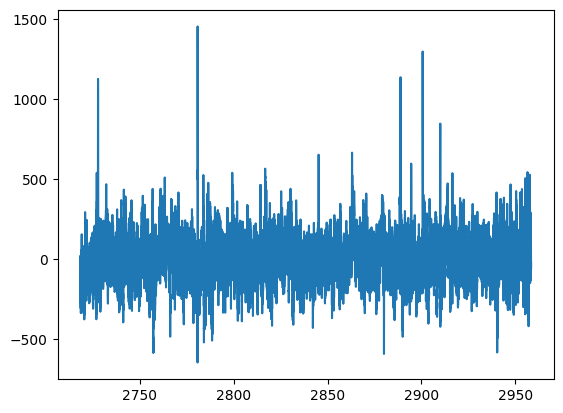

In [52]:
fig, ax = plt.subplots()
ax.plot(t[t_init:t_end], epoch_bip)

In [53]:
f.close()

## Get channels info

In [8]:
file2 = "/scratch/mcesped/HippiEEGAtlas/epochs/results/sub-003/ses-007/ieeg/sub-003_ses-007_task-full_run-02_ieeg_epoch.edf"
f2 = pyedflib.EdfReader(file2)

In [54]:
file2 = "/scratch/mcesped/HippiEEGAtlas/code/DSP/test2.edf"
f2 = pyedflib.EdfReader(file2)

**Important: pyedf uses int32 to write the values so you have to read them in this format!**

In [19]:
f2.getSignalLabels()

['LAHc1-2',
 'LAHc2-3',
 'LAHc3-4',
 'LAHc4-5',
 'LAHc5-6',
 'LAHc6-7',
 'LAHc7-8',
 'LAHc8-9',
 'LAHc9-10',
 'RAHc1-2',
 'RAHc2-3',
 'RAHc3-4',
 'RAHc4-5',
 'RAHc5-6',
 'RAHc6-7',
 'RAHc7-8',
 'RAHc8-9',
 'RAHc9-10',
 'RAIn1-2',
 'RAIn2-3',
 'RAIn3-4',
 'RAIn4-5',
 'RAIn5-6',
 'RAIn6-7',
 'RAIn7-8',
 'RAIn8-9',
 'RAIn9-10',
 'RAm1-2',
 'RAm2-3',
 'RAm3-4',
 'RAm4-5',
 'RAm5-6',
 'RAm6-7',
 'RAm7-8',
 'RAm8-9',
 'RAm9-10',
 'RCeO1-2',
 'RCeO2-3',
 'RCeO3-4',
 'RCeO4-5',
 'RCeO5-6',
 'RCeO6-7',
 'RCeO7-8',
 'RCeO8-9',
 'RCeO9-10',
 'ROFr1-2',
 'ROFr2-3',
 'ROFr3-4',
 'ROFr4-5',
 'ROFr5-6',
 'ROFr6-7',
 'ROFr7-8',
 'ROFr8-9',
 'ROFr9-10',
 'RPHc1-2',
 'RPHc2-3',
 'RPHc3-4',
 'RPHc4-5',
 'RPHc5-6',
 'RPHc6-7',
 'RPHc7-8',
 'RPHc8-9',
 'RPHc9-10',
 'RPIn1-2',
 'RPIn2-3',
 'RPIn3-4',
 'RPIn4-5',
 'RPIn5-6',
 'RPIn6-7',
 'RPIn7-8',
 'RPIn8-9',
 'RPIn9-10',
 'RTeP1-2',
 'RTeP2-3',
 'RTeP3-4',
 'RTeP4-5',
 'RTeP5-6',
 'RTeP6-7',
 'RTeP7-8',
 'RTeP8-9',
 'RTeP9-10']

In [24]:
f2.getSignalHeader(50)

{'label': 'ROFr6-7',
 'dimension': 'uV',
 'sample_rate': 128.0,
 'sample_frequency': 128.0,
 'physical_max': -8711.0,
 'physical_min': 8711.0,
 'digital_max': 32767,
 'digital_min': -32768,
 'prefilter': '',
 'transducer': ''}

In [9]:
signal2 = f2.readSignal(0).astype('int32')

In [10]:
signal2

array([17, 18, 16, ...,  0,  0,  0], dtype=int32)

In [11]:
signal2[len(signal2)-15:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [12]:
len(signal2)

307328

In [13]:
len(f2.getSignalHeaders())

81

In [14]:
annot2 = f2.readAnnotations()
annot2 = {
    'Onset': annot2[0],
    'Duration': annot2[1],
    'event': annot2[2]
}
annot2 = pd.DataFrame(annot2)
annot2.head()

,Onset,Duration,event
0,-0.00003,-1.0,Recording starts
1,-0.00003,-1.0,Epoch #1 starts.
2,240.00097,-1.0,Epoch #1 ends.


In [15]:
N = signal2.shape[0]
srate2 = (f2.getSampleFrequencies()[0]/f2.datarecord_duration)
t = np.arange(0, N)/srate2
t_test = np.argmin((np.abs(t-annot2.Onset.to_numpy()[2])))

In [16]:
f2.datarecord_duration

0.125

In [17]:
t_test

245761

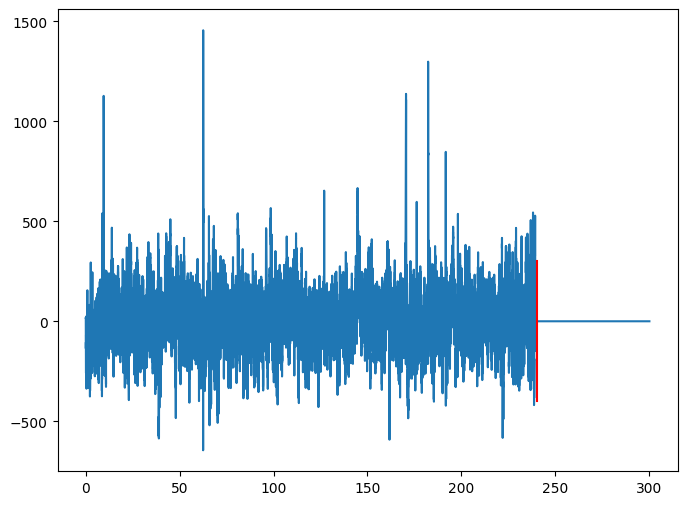

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t,signal2)
ax.plot([t[t_test], t[t_test]], [-400,300], 'r')

In [25]:
f2.close()

## Extract edf files from path

In [5]:
import os, fnmatch
import re
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [2]:
list_paths = find("*ieeg.edf","/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/epi_iEEG/ieeg/bids/sub-002/")

In [4]:
list_paths[0]

'/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/epi_iEEG/ieeg/bids/sub-002/ses-003/ieeg/sub-002_ses-003_task-full_run-04_ieeg.edf'

In [43]:
pattern = r'sub-\d{3}_ses-\d{3}_task-(.+)_run-\d{2}_ieeg'

In [44]:
caca= re.search(pattern=pattern, string=list_paths[0]).group()
print(caca)

sub-002_ses-003_task-full_run-04_ieeg
